In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [2]:
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from datasets import train_test_random_split, load_celeba, CustomDSpritesDatasetFactorVAE
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAECelebA, Classifier
from utils import latent_transversal, load_checkpoint, save_checkpoint
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae

In [3]:
image_size = (64, 64)
dataset = ImageFolder('./celeba/', transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.ToTensor()
                                ]))

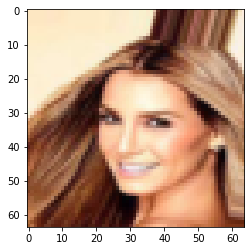

In [4]:
plt.imshow(dataset[0][0].permute(1, 2, 0).numpy())
plt.show()

In [5]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
data_train, data_test = train_test_random_split(dataset, 0.8)

batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [7]:
def train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device=None):
    model.train()

    train_loss = []
    for epoch in range(epochs):
        epoch_loss = []
        recon_losses = []
        for batch_idx, (data, _) in enumerate(train_loader):

            data = data.float()
            if device != None:
                data = data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            recon, mu, logvar = model(data)
            loss, recon_loss = loss_beta_vae(recon, data, mu, logvar, beta, distribution)
            loss.backward()
            optimizer.step()
            # print statistics
            epoch_loss.append(loss.item())
            recon_losses.append(recon_loss.item())
        epoch_loss = np.mean(epoch_loss)
        recon_losses = np.mean(recon_losses)
        train_loss.append((epoch_loss, recon_losses,))
        print("Epoch " + str(epoch) + " finished, loss: " + str((epoch_loss, recon_losses,)))
    return train_loss


def test_beta_vae(model, test_loader, beta, distribution, device=None):
    model.eval()

    test_loss = []
    recon_losses = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.float()
            if device != None:
                data = data.to(device)
            # report the average loss over the test dataset
            recon, mu, logvar = model(data)
            loss, recon_loss = loss_beta_vae(recon, data, mu, logvar, beta, distribution)
            test_loss.append(loss.item())
            recon_losses.append(recon_loss.item())
    test_loss = np.mean(test_loss)
    recon_losses = np.mean(recon_losses)
    print("Test total loss: " + str(test_loss) + 'Test recon loss: ' + str(recon_losses))

In [18]:
model = BetaVAECelebA()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [19]:
# train the model
epochs = 10
beta = 250
distribution = 'gaussian'


In [20]:
import time

In [21]:
def plot_recon_image(model, dataset, index):
    plt.imshow(torch.sigmoid(model(dataset[index][0].view(1, 3, 64, 64).cuda())[0]).view(3,64,64).cpu().permute(1, 2, 0).detach().numpy())
    plt.show()

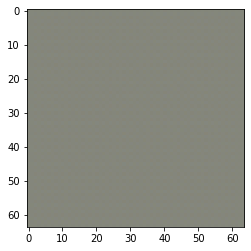

In [22]:
plot_recon_image(model, dataset, 12332)

In [23]:
start = time.time()
loss_list = []
losses = train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device)
loss_list.append(losses)
save_checkpoint(model, optimizer, 'betavae_celeba_beta4_e10_r.pth.tar', 
    loss_list, 10)

/home/hzzhyj/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/hzzhyj/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: (974.6588309943511, 973.8020584823302)
Epoch 1 finished, loss: (958.1995865994652, 957.237418492886)
Epoch 2 finished, loss: (936.4914629816114, 894.4478171341418)
Epoch 3 finished, loss: (909.4319298010404, 826.3268141778524)
Epoch 4 finished, loss: (888.87121878412, 783.6211227374824)
Epoch 5 finished, loss: (877.1689993357217, 759.6272510719826)
Epoch 6 finished, loss: (875.8722874174182, 756.939203972408)
Epoch 7 finished, loss: (874.2456924552932, 755.4534960301365)
Epoch 8 finished, loss: (873.9585719720394, 754.6569704702613)
Epoch 9 finished, loss: (873.6988030217921, 753.4967992325522)


In [54]:
save_checkpoint(model, optimizer, 'betavae_celeba_beta4_e10.pth.tar', 
    loss_list, 10)

In [52]:
print('10 Epochs')
end = time.time()
print('time used in minutes:', (end-start)/60)

10 Epochs
time used in minutes: 38.157957216103874


In [ ]:
print('Training started')
for i in range(10):
    losses = train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device)
    loss_list.append(losses)
    save_checkpoint(model, optimizer, 'betavae_celeba_beta4_e' + str(i+1) + '0.pth.tar', 
        loss_list, (i+1)*10)
    print(str(i+1) + '0 Epochs')
    end = time.time()
    print('time used in minutes:', (end-start)/60)
print('Training finished')

end = time.time()

In [9]:
loss_list = []
model, optimizer, start_epoch, loss_list = load_checkpoint(model, optimizer, loss_list, filename='betavae_celeba_beta4_e10.pth.tar')

=> loading checkpoint 'betavae_celeba_beta4_e10.pth.tar'
=> loaded checkpoint 'betavae_celeba_beta4_e10.pth.tar' (epoch 11)


In [10]:
plot_recon_image(model, dataset, 29091)

NameError: name 'plot_recon_image' is not defined

In [16]:
loss_list

[[(968.600097391194, 967.9767334851831),
  (955.4301621911086, 949.6812178366654),
  (916.6390850008405, 841.1166125213587),
  (901.1252220445973, 809.5379735296816),
  (879.0895948142719, 763.4370398146806),
  (876.2053389882458, 757.5730171549993),
  (874.5836459708412, 755.5886776484004),
  (874.2190626455398, 754.4873758670703),
  (873.4755421309804, 753.9125028867003),
  (873.0432979012967, 753.3148160347862)]]

In [17]:
losses = train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device)
loss_list.append(losses)

/home/hzzhyj/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/hzzhyj/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: (872.0932909953843, 752.2426477576074)
Epoch 1 finished, loss: (872.25624356155, 752.2875524039707)
Epoch 2 finished, loss: (872.3366690062272, 751.6440193064825)
Epoch 3 finished, loss: (872.092944639547, 751.8009647651006)
Epoch 4 finished, loss: (871.7279798023511, 751.2999070954803)
Epoch 5 finished, loss: (871.7589483852213, 751.4276795807066)
Epoch 6 finished, loss: (871.6587565618214, 751.2335008213843)
Epoch 7 finished, loss: (871.5944468320898, 751.2889225745549)
Epoch 8 finished, loss: (871.4404939033276, 750.4632156558814)
Epoch 9 finished, loss: (870.9358701468738, 750.5551051558876)


NameError: name 'i' is not defined

In [18]:
save_checkpoint(model, optimizer, 'betavae_celeba_beta4_e20.pth.tar', 
    loss_list, 20)

In [19]:
losses = train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device)
loss_list.append(losses)
save_checkpoint(model, optimizer, 'betavae_celeba_beta4_e30.pth.tar', 
    loss_list, 30)

Epoch 0 finished, loss: (870.287961288916, 750.1254552697363)
Epoch 1 finished, loss: (870.864730431353, 750.3070164261436)
Epoch 2 finished, loss: (871.0608546290528, 750.264040616017)
Epoch 3 finished, loss: (871.5414021488616, 750.7420690922788)
Epoch 4 finished, loss: (871.1428703853277, 749.9775357372527)
Epoch 5 finished, loss: (871.6845451080889, 750.5908484566226)
Epoch 6 finished, loss: (871.3058924443441, 750.3352519448359)
Epoch 7 finished, loss: (871.2266177521174, 750.0598017545354)
Epoch 8 finished, loss: (870.4814409511248, 750.189084359887)
Epoch 9 finished, loss: (870.2959052807627, 749.9623166342946)


In [20]:
losses = train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device)
loss_list.append(losses)
save_checkpoint(model, optimizer, 'betavae_celeba_beta4_e40.pth.tar', 
    loss_list, 40)

Epoch 0 finished, loss: (870.9678355087841, 749.8047215235455)
Epoch 1 finished, loss: (871.3537866808518, 749.7133750026987)
Epoch 2 finished, loss: (871.1425902693817, 749.9631727168177)
Epoch 3 finished, loss: (871.295727163165, 750.0265966777598)
Epoch 4 finished, loss: (870.6314884973428, 749.9919856719429)
Epoch 5 finished, loss: (870.4203461090943, 749.524481675863)
Epoch 6 finished, loss: (870.9640819069147, 749.7096031601609)
Epoch 7 finished, loss: (870.885741729676, 749.6936953213673)
Epoch 8 finished, loss: (871.189234622514, 749.5844713550663)
Epoch 9 finished, loss: (871.0329705263567, 749.9818358362968)


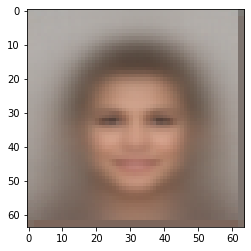

In [ ]:
losses = train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device)
loss_list.append(losses)
save_checkpoint(model, optimizer, 'betavae_celeba_beta4_e50.pth.tar', 
    loss_list, 50)